In [33]:
# ----------------------------- 1. Imports -----------------------------
import os
import random
from pathlib import Path

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts



In [34]:
# ----------------------------- 2. Reproducibility -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [35]:
# ----------------------------- 3. Hyper-parameters -----------------------------
BATCH_SIZE     = 128
EPOCHS         = 60
NUM_CLASSES    = 10
IMG_SHAPE      = (28, 28, 1)
AUTO           = tf.data.AUTOTUNE

# Mixing augmentations
USE_CUTMIX     = True
USE_MIXUP      = True
CUTMIX_PROB    = 0.7
MIXUP_PROB     = 0.3
ALPHA          = 0.2          # Beta(alpha, alpha) for mixing

In [36]:
# Optimizer
INIT_LR        = 1e-3
WD             = 1e-4          # weight decay
LABEL_SMOOTH   = 0.05

# Stochastic depth
DROP_PATH_RATES = [0.05, 0.07, 0.09, 0.12]

In [37]:
# ----------------------------- 4. Class names -----------------------------
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

**Data Pipeline**

In [38]:
def load_data():
    """Load Fashion-MNIST and create train/val/test splits."""
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # Scale to [0,1] and add channel dim
    x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]
    x_test  = (x_test.astype("float32")  / 255.0)[..., np.newaxis]

    # 90 % train, 10 % validation (stratified)
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
    )
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)



In [39]:
# ----------------------------- Augmentations -----------------------------
aug_layer = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.12),
        layers.RandomTranslation(0.08, 0.08),
        layers.RandomContrast(0.1),
    ],
    name="augmentation",
)

In [40]:
# ----------------------------- Mixing helpers -----------------------------
def one_hot(y):
    return tf.one_hot(y, NUM_CLASSES)


def sample_beta(batch_size, alpha):
    g1 = tf.random.gamma([batch_size], alpha)
    g2 = tf.random.gamma([batch_size], alpha)
    return g1 / (g1 + g2)


def mixup(images, labels, alpha=ALPHA):
    bs = tf.shape(images)[0]
    lam = sample_beta(bs, alpha)
    lam_x = tf.reshape(lam, (bs, 1, 1, 1))
    lam_y = tf.reshape(lam, (bs, 1))

    idx = tf.random.shuffle(tf.range(bs))
    images2 = tf.gather(images, idx)
    labels2 = tf.gather(labels, idx)

    return images * lam_x + images2 * (1.0 - lam_x), labels * lam_y + labels2 * (1.0 - lam_y)


def rand_bbox(height, width, lam):
    cut_rat = tf.sqrt(1.0 - lam)
    cut_h = tf.cast(tf.cast(height, tf.float32) * cut_rat, tf.int32)
    cut_w = tf.cast(tf.cast(width, tf.float32) * cut_rat, tf.int32)

    cy = tf.random.uniform([], 0, height, dtype=tf.int32)
    cx = tf.random.uniform([], 0, width, dtype=tf.int32)

    y1 = tf.clip_by_value(cy - cut_h // 2, 0, height)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, height)
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, width)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, width)
    return y1, y2, x1, x2


def cutmix(images, labels, alpha=ALPHA):
    bs = tf.shape(images)[0]
    h, w = tf.shape(images)[1], tf.shape(images)[2]
    lam = sample_beta(bs, alpha)  # area ratio for original image
    idx = tf.random.shuffle(tf.range(bs))
    images2 = tf.gather(images, idx)
    labels2 = tf.gather(labels, idx)

    mixed = tf.identity(images)
    for i in tf.range(bs):
        y1, y2, x1, x2 = rand_bbox(h, w, lam[i])
        patch = images2[i, y1:y2, x1:x2, :]
        paddings = [[y1, h - y2], [x1, w - x2], [0, 0]]
        patch_pad = tf.pad(patch, paddings)
        mask = tf.pad(tf.ones_like(patch), paddings)

        mixed = mixed * (1.0 - tf.cast(mask, mixed.dtype)) + patch_pad

        # exact lambda for this patch
        area = tf.cast((y2 - y1) * (x2 - x1), tf.float32)
        lam_i = 1.0 - area / tf.cast(h * w, tf.float32)
        labels = tf.tensor_scatter_nd_update(
            labels, [[i]], [labels[i] * lam_i + labels2[i] * (1.0 - lam_i)]
        )
    return mixed, labels


def mixing_fn(images, labels):
    if USE_CUTMIX and tf.random.uniform([]) < CUTMIX_PROB:
        return cutmix(images, labels)
    if USE_MIXUP and tf.random.uniform([]) < MIXUP_PROB:
        return mixup(images, labels)
    return images, labels

In [41]:

# ----------------------------- Dataset builder -----------------------------
def build_dataset(x, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(8192, seed=SEED)

    ds = ds.map(lambda xx, yy: (xx, one_hot(yy)), num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE)

    if training:
        ds = ds.map(lambda xx, yy: (aug_layer(xx, training=True), yy), num_parallel_calls=AUTO)
        ds = ds.map(mixing_fn, num_parallel_calls=AUTO)

    return ds.prefetch(AUTO)

**Model Architecture**

In [42]:
# ----------------------------- Stochastic Depth -----------------------------
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prob, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = float(drop_prob)

    def call(self, x, training=None):
        if not training or self.drop_prob == 0.0:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape)
        binary_tensor = tf.floor(random_tensor)
        return (x / keep_prob) * binary_tensor


# ----------------------------- SE-Block -----------------------------
def se_block(x, r=8):
    ch = x.shape[-1]
    s = layers.GlobalAveragePooling2D()(x)
    s = layers.Dense(max(ch // r, 8), activation="relu")(s)
    s = layers.Dense(ch, activation="sigmoid")(s)
    s = layers.Reshape((1, 1, ch))(s)
    return layers.Multiply()([x, s])


# ----------------------------- Residual SE Block -----------------------------
def residual_se_block(x, filters, stride=1, drop_path=0.0):
    shortcut = x

    x = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([shortcut, StochasticDepth(drop_path)(x)])
    return layers.Activation("relu")(x)




In [43]:
# ----------------------------- Build Model -----------------------------
def build_model():
    inputs = layers.Input(IMG_SHAPE)
    x = aug_layer(inputs)  # light augmentation even outside mixing

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Residual stages
    filters = [48, 64, 96, 128]
    strides = [1, 2, 1, 2]
    for f, s, d in zip(filters, strides, DROP_PATH_RATES):
        x = residual_se_block(x, f, stride=s, drop_path=d)

    x = layers.Conv2D(192, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(192, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return models.Model(inputs, outputs, name="FMNIST_ResSE_CutMix")

**Training**

In [44]:
def get_optimizer():
    steps = int(np.ceil(len(x_train) / BATCH_SIZE))
    lr_schedule = CosineDecayRestarts(INIT_LR, first_decay_steps=steps * 5)

    try:
        return optimizers.AdamW(learning_rate=lr_schedule, weight_decay=WD)
    except AttributeError:
        print("AdamW not available – falling back to Adam")
        return optimizers.Adam(learning_rate=lr_schedule)


def train(model):
    model.compile(
        optimizer=get_optimizer(),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH),
        metrics=["accuracy"],
    )

    cbs = [
        callbacks.EarlyStopping(
            monitor="val_accuracy", patience=10, restore_best_weights=True
        ),
        callbacks.ModelCheckpoint(
            "best_fmnist_cutmix.keras", monitor="val_accuracy", save_best_only=True, verbose=1
        ),
    ]

    return model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cbs,
        verbose=2,
    )

**Evaluation & Visualization**

In [45]:
def evaluate(model):
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print(f"\nTest accuracy: {test_acc:.4f}  |  Test loss: {test_loss:.4f}")

    probs = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in test_ds], axis=0)

    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES,
        cmap="Blues",
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix – ResSE + CutMix")
    plt.tight_layout()
    plt.show()


def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(history.history["accuracy"], label="Train")
    ax[0].plot(history.history["val_accuracy"], label="Val")
    ax[0].set_title("Accuracy")
    ax[0].legend()

    ax[1].plot(history.history["loss"], label="Train")
    ax[1].plot(history.history["val_loss"], label="Val")
    ax[1].set_title("Loss")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

**Main Entry Point**

Model: "FMNIST_ResSE_CutMix"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 28, 28, 1) │          0 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28,    │        288 │ augmentation[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │     13,824 │ activation_10[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        192 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 28, 28,    │     20,736 │ activation_11[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        192 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 8)         │        392 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 48)        │        432 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 48)  │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 28, 28,    │      1,536 │ activation_10[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 48)               │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        192 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_4  │ (None, 28, 28,    │          0 │ multiply_4[0][0]

 Total params: 792,358 (3.02 MB)

 Trainable params: 789,894 (3.01 MB)

 Non-trainable params: 2,464 (9.62 KB)

Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.14250, saving model to best_fmnist_cutmix.keras
422/422 - 54s - 128ms/step - accuracy: 0.2139 - loss: 2.1137 - val_accuracy: 0.1425 - val_loss: 2.4778
Epoch 2/60

Epoch 2: val_accuracy improved from 0.14250 to 0.57333, saving model to best_fmnist_cutmix.keras
422/422 - 40s - 95ms/step - accuracy: 0.2583 - loss: 1.9971 - val_accuracy: 0.5733 - val_loss: 1.3377
Epoch 3/60

Epoch 3: val_accuracy improved from 0.57333 to 0.66767, saving model to best_fmnist_cutmix.keras
422/422 - 38s - 89ms/step - accuracy: 0.2775 - loss: 1.9524 - val_accuracy: 0.6677 - val_loss: 1.2375
Epoch 4/60

Epoch 4: val_accuracy improved from 0.66767 to 0.68150, saving model to best_fmnist_cutmix.keras
422/422 - 41s - 97ms/step - accuracy: 0.2843 - loss: 1.9324 - val_accuracy: 0.6815 - val_loss: 1.1469
Epoch 5/60

Epoch 5: val_accuracy improved from 0.68150 to 0.69383, saving model to best_fmnist_cutmix.keras
422/422 - 37s - 89ms/step - accuracy: 0.2908 - lo

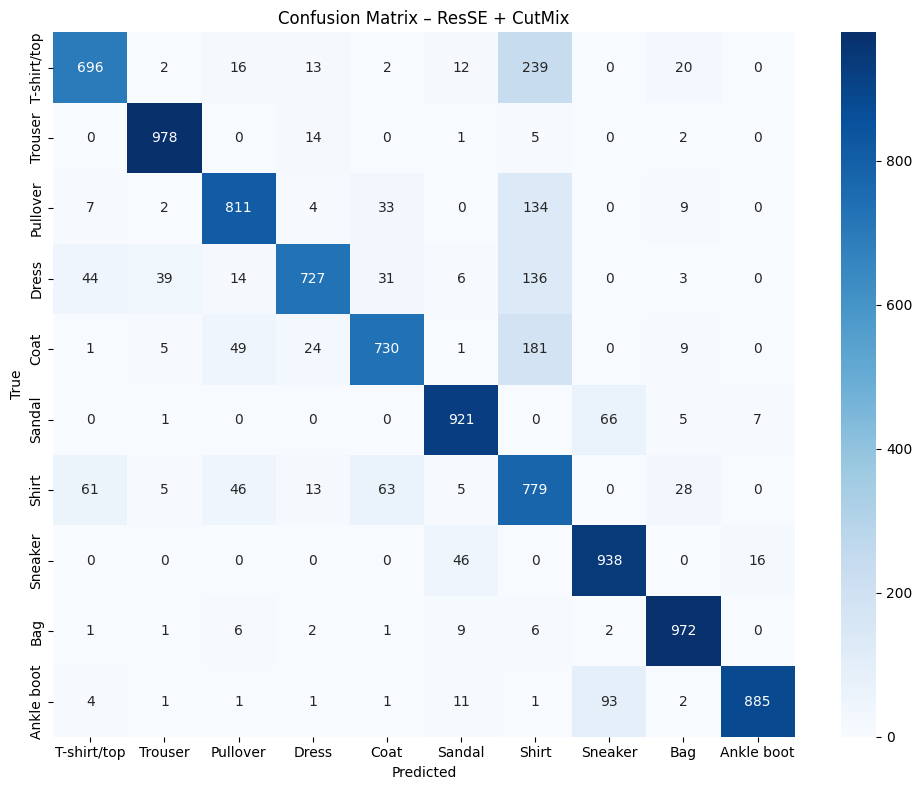

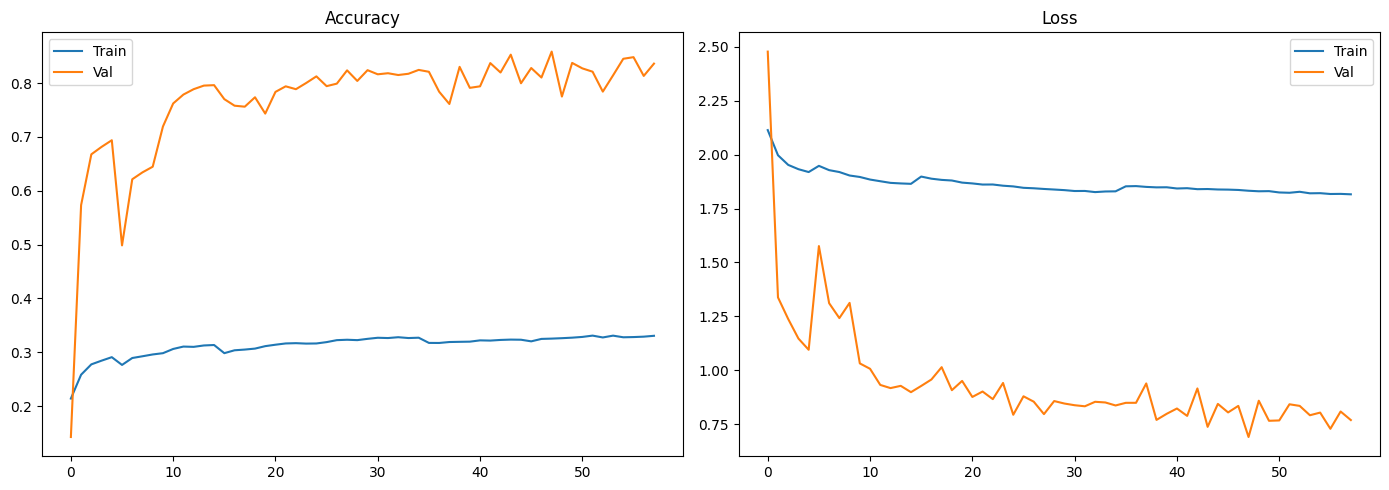

In [46]:
if __name__ == "__main__":
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

    train_ds = build_dataset(x_train, y_train, training=True)
    val_ds   = build_dataset(x_val,   y_val,   training=False)
    test_ds  = build_dataset(x_test,  y_test,  training=False)

    model = build_model()
    model.summary()

    hist = train(model)
    evaluate(model)
    plot_history(hist)

